# **Prototyping**

In this notebook, we will explore the nature of our data, first by using the skin cancer dataset from kaggle.

In [ ]:
%matplotlib inline

import kaggle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
from pathlib import Path
from glob import glob
import seaborn as sns

from PIL import Image

np.random.seed(42)

from sklearn.utils import resample
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import itertools

from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
# !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p ../data/raw --unzip -o -q

## **Step 2: Making Dictionary of images and labels**

In [3]:
BASE_SKIN_DIR = Path( "../data/raw/HAM10000_images" )
imageid_path_dict = { os.path.splitext( os.path.basename( f ) )[ 0 ] : f
                     for f in list( BASE_SKIN_DIR.rglob( "*.jpg" ) ) }

skin_lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

## **Step 3: Reading and Processing the Data**

In [4]:
skin_df = pd.read_csv( "../data/raw/HAM10000_metadata.csv" )

skin_df[ 'path' ] = skin_df[ 'image_id' ].map( imageid_path_dict.get )
skin_df[ 'cell_type' ] = skin_df[ 'dx' ].map( skin_lesion_type_dict.get )
skin_df[ 'cell_type_idx' ] = pd.Categorical( skin_df[ 'cell_type' ] ).codes

In [5]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\data\raw\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2


derive only non-duplicates id for duplicate images

In [6]:
skin_df_undup = skin_df.copy()
skin_df_undup.drop_duplicates( subset=[ 'lesion_id' ], keep='first', inplace=True )

In [7]:
skin_df_undup

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\data\raw\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,..\data\raw\HAM10000_images\ISIC_0029176.jpg,Benign keratosis-like lesions,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,..\data\raw\HAM10000_images\ISIC_0025837.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
9994,HAM_0000193,ISIC_0030877,akiec,histo,60.0,female,face,..\data\raw\HAM10000_images\ISIC_0030877.jpg,Actinic keratoses,0
10001,HAM_0000020,ISIC_0031922,akiec,histo,60.0,female,face,..\data\raw\HAM10000_images\ISIC_0031922.jpg,Actinic keratoses,0
10004,HAM_0005579,ISIC_0029309,akiec,histo,80.0,male,face,..\data\raw\HAM10000_images\ISIC_0029309.jpg,Actinic keratoses,0
10008,HAM_0001576,ISIC_0033705,akiec,histo,60.0,male,face,..\data\raw\HAM10000_images\ISIC_0033705.jpg,Actinic keratoses,0


In [8]:
test_dup = skin_df.groupby( [ 'lesion_id' ] ).count()
test_dup = test_dup[ test_dup[ 'image_id' ] == 1 ]
test_dup.reset_index( inplace=True )
test_dup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [9]:
test_dup

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
5509,HAM_0007622,1,1,1,1,1,1,1,1,1
5510,HAM_0007623,1,1,1,1,1,1,1,1,1
5511,HAM_0007624,1,1,1,1,1,1,1,1,1
5512,HAM_0007626,1,1,1,1,1,1,1,1,1


In [10]:
def get_duplicates( x ):
    unique_ids = list( test_dup[ 'lesion_id' ] )
    if x in unique_ids:
        return 'unduplicated'
    else:
        return 'duplicated'
    
skin_df[ 'duplicates' ] = skin_df[ 'lesion_id' ]
skin_df[ 'duplicates' ] = skin_df[ 'lesion_id' ].apply( get_duplicates )
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\data\raw\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [11]:
skin_df[ 'duplicates' ].value_counts()

duplicates
unduplicated    5514
duplicated      4501
Name: count, dtype: int64

In [12]:
skin_df_undup[  'duplicates' ] = skin_df_undup[ 'lesion_id' ].apply( get_duplicates )

In [13]:
skin_df_undup.reset_index( inplace=True, drop=True )

In [14]:
skin_df_undup

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\data\raw\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,..\data\raw\HAM10000_images\ISIC_0029176.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,..\data\raw\HAM10000_images\ISIC_0025837.jpg,Benign keratosis-like lesions,2,duplicated
...,...,...,...,...,...,...,...,...,...,...,...
7465,HAM_0000193,ISIC_0030877,akiec,histo,60.0,female,face,..\data\raw\HAM10000_images\ISIC_0030877.jpg,Actinic keratoses,0,duplicated
7466,HAM_0000020,ISIC_0031922,akiec,histo,60.0,female,face,..\data\raw\HAM10000_images\ISIC_0031922.jpg,Actinic keratoses,0,unduplicated
7467,HAM_0005579,ISIC_0029309,akiec,histo,80.0,male,face,..\data\raw\HAM10000_images\ISIC_0029309.jpg,Actinic keratoses,0,duplicated
7468,HAM_0001576,ISIC_0033705,akiec,histo,60.0,male,face,..\data\raw\HAM10000_images\ISIC_0033705.jpg,Actinic keratoses,0,unduplicated


In [15]:
y = skin_df_undup[ 'cell_type_idx' ]
_, val_df = train_test_split( skin_df_undup, test_size=0.2, 
                             stratify=y, random_state=42 )

val_df.shape

(1494, 11)

In [16]:
val_df[ 'cell_type_idx' ].value_counts()

cell_type_idx
4    1080
2     145
5     123
1      65
0      46
6      20
3      15
Name: count, dtype: int64

In [76]:
def get_val_rows( x ):
    if x in list( val_df[ 'image_id' ] ):
        return 'val'
    else:
        return 'train'

skin_df[ 'set' ] = skin_df[ 'image_id' ].apply( get_val_rows )
skin_df_undup[ 'set' ] = skin_df_undup[ 'image_id' ].apply( get_val_rows )

In [95]:
train_df = skin_df_undup[ skin_df_undup[ 'set' ] == 'train' ]

In [96]:
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates,set
1,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\data\raw\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated,train
2,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\data\raw\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated,train
3,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,..\data\raw\HAM10000_images\ISIC_0029176.jpg,Benign keratosis-like lesions,2,duplicated,train
5,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,..\data\raw\HAM10000_images\ISIC_0025276.jpg,Benign keratosis-like lesions,2,unduplicated,train
6,HAM_0004234,ISIC_0029396,bkl,histo,85.0,female,chest,..\data\raw\HAM10000_images\ISIC_0029396.jpg,Benign keratosis-like lesions,2,duplicated,train


In [98]:
train_df.shape

(5976, 12)

In [97]:
train_df[ 'cell_type_idx' ].value_counts()

cell_type_idx
4    4323
2     582
5     491
1     262
0     182
6      78
3      58
Name: count, dtype: int64

## **Step 4: Data Cleansing and Imputation**

In [99]:
n_iterated = train_df[ 'cell_type_idx' ].unique().max() + 1
n_samples = train_df[ 'cell_type_idx' ].value_counts().max()

class_counts = train_df[ 'cell_type_idx' ].value_counts()

dfs_to_combine = [ train_df ]

for i in range( n_iterated ):
    multiplier = int( np.floor( n_samples / class_counts[ i ] ) )
    
    if multiplier > 0:
        subset = train_df.loc[ train_df[ 'cell_type_idx' ] == i, : ]

        copies = [ subset ] * ( multiplier - 1 )
        dfs_to_combine.extend( copies )

train_df = pd.concat( dfs_to_combine, ignore_index=True ).reset_index( drop=True )

In [100]:
train_df[ 'cell_type_idx' ].value_counts()

cell_type_idx
4    4323
3    4292
6    4290
1    4192
0    4186
2    4074
5    3928
Name: count, dtype: int64

In [101]:
train_df.isnull().sum()

lesion_id          0
image_id           0
dx                 0
dx_type            0
age              108
sex                0
localization       0
path               0
cell_type          0
cell_type_idx      0
duplicates         0
set                0
dtype: int64

In [102]:
train_df.loc[ train_df[ 'age' ].isnull(), : ]

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates,set
471,HAM_0001186,ISIC_0033391,bkl,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033391.jpg,Benign keratosis-like lesions,2,unduplicated,train
472,HAM_0002660,ISIC_0033750,bkl,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033750.jpg,Benign keratosis-like lesions,2,unduplicated,train
473,HAM_0000372,ISIC_0033685,bkl,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033685.jpg,Benign keratosis-like lesions,2,unduplicated,train
474,HAM_0000948,ISIC_0033631,bkl,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033631.jpg,Benign keratosis-like lesions,2,unduplicated,train
475,HAM_0000983,ISIC_0033490,bkl,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033490.jpg,Benign keratosis-like lesions,2,unduplicated,train
...,...,...,...,...,...,...,...,...,...,...,...,...
22901,HAM_0000169,ISIC_0032960,mel,histo,NaN,male,face,..\data\raw\HAM10000_images\ISIC_0032960.jpg,Melanoma,5,duplicated,train
23392,HAM_0000169,ISIC_0032960,mel,histo,NaN,male,face,..\data\raw\HAM10000_images\ISIC_0032960.jpg,Melanoma,5,duplicated,train
23883,HAM_0000169,ISIC_0032960,mel,histo,NaN,male,face,..\data\raw\HAM10000_images\ISIC_0032960.jpg,Melanoma,5,duplicated,train
24374,HAM_0000169,ISIC_0032960,mel,histo,NaN,male,face,..\data\raw\HAM10000_images\ISIC_0032960.jpg,Melanoma,5,duplicated,train


In [103]:
train_df.groupby( [ 'dx_type' ] )[ 'age' ].mean().round( 0 )

dx_type
confocal     67.0
consensus    54.0
follow_up    49.0
histo        62.0
Name: age, dtype: float64

In [104]:
train_df.groupby( [ 'dx' ] )[ 'age' ].mean().round( 0 )

dx
akiec    67.0
bcc      67.0
bkl      65.0
df       54.0
mel      61.0
nv       47.0
vasc     53.0
Name: age, dtype: float64

In [105]:
val_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              5
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
duplicates       0
age_imputed      0
dtype: int64

In [106]:
val_df.loc[ val_df[ 'age' ].isnull(), : ]

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates,age_imputed
7203,HAM_0003034,ISIC_0033187,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033187.jpg,Melanocytic nevi,4,unduplicated,38.0
7210,HAM_0001433,ISIC_0033735,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033735.jpg,Melanocytic nevi,4,unduplicated,38.0
7201,HAM_0001139,ISIC_0033028,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033028.jpg,Melanocytic nevi,4,unduplicated,38.0
7179,HAM_0000822,ISIC_0033841,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033841.jpg,Melanocytic nevi,4,unduplicated,38.0
7206,HAM_0003017,ISIC_0033535,nv,consensus,NaN,unknown,unknown,..\data\raw\HAM10000_images\ISIC_0033535.jpg,Melanocytic nevi,4,unduplicated,38.0


In [28]:
val_df.groupby( [ 'dx_type' ] )[ 'age' ].mean().round( 0 )

dx_type
confocal     63.0
consensus    47.0
follow_up    48.0
histo        55.0
Name: age, dtype: float64

In [29]:
val_df.groupby( [ 'dx' ] )[ 'age' ].mean().round( 0 )

dx
akiec    66.0
bcc      66.0
bkl      63.0
df       49.0
mel      62.0
nv       47.0
vasc     52.0
Name: age, dtype: float64

[Text(0.5, 1.0, 'Train Set : Stacked Histogram of Age Distribution by Sex'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count')]

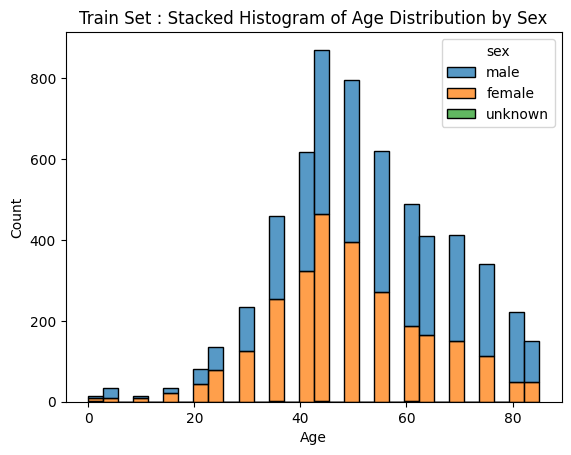

In [30]:
ax = sns.histplot( data=train_df, 
             x='age', 
             hue='sex', 
             multiple='stack', 
             bins=30 )

ax.set( title='Train Set : Stacked Histogram of Age Distribution by Sex',
       xlabel='Age', ylabel='Count' )

[Text(0.5, 1.0, 'Train Set : Stacked Histogram of Age Distribution by dx'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count')]

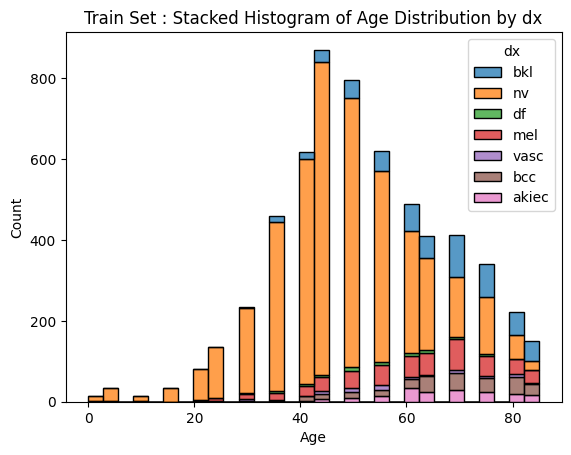

In [31]:
ax = sns.histplot( data=train_df, 
             x='age', 
             hue='dx', 
             multiple='stack', 
             bins=30 )

ax.set( title='Train Set : Stacked Histogram of Age Distribution by dx',
       xlabel='Age', ylabel='Count' )

[Text(0.5, 1.0, 'Test Set : Stacked Histogram of Age Distribution by Sex'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count')]

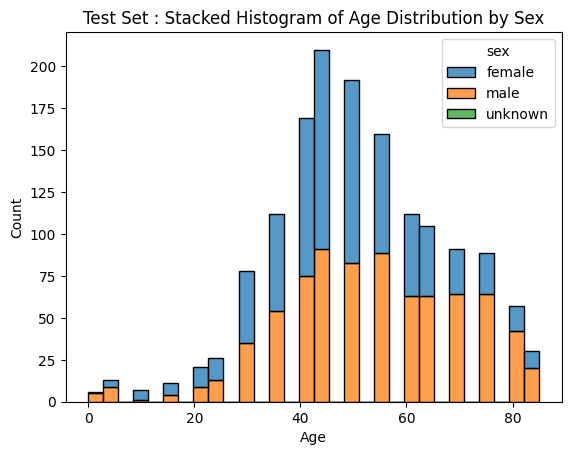

In [32]:
ax = sns.histplot( data=val_df, 
             x='age', 
             hue='sex', 
             multiple='stack', 
             bins=30 )

ax.set( title='Test Set : Stacked Histogram of Age Distribution by Sex',
       xlabel='Age', ylabel='Count' )

[Text(0.5, 1.0, 'Test Set : Stacked Histogram of Age Distribution by dx'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Count')]

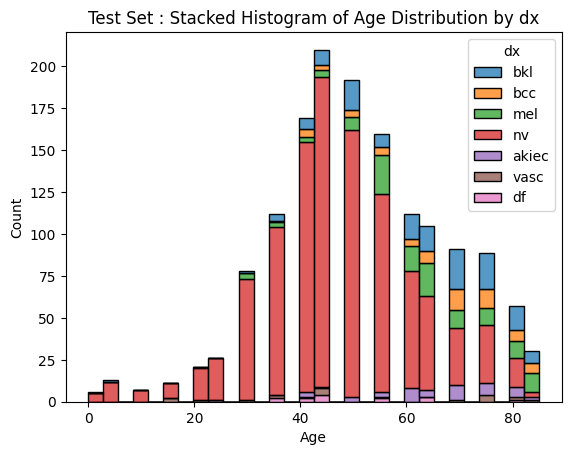

In [33]:
ax = sns.histplot( data=val_df, 
             x='age', 
             hue='dx', 
             multiple='stack', 
             bins=30 )

ax.set( title='Test Set : Stacked Histogram of Age Distribution by dx',
       xlabel='Age', ylabel='Count' )

In [34]:
train_L1_series = train_df.groupby( [ 'dx', 'dx_type' ] )[ 'age' ].transform( 'mean' ).round( 0 )
train_L2_series = train_df.groupby( [ 'dx' ] )[ 'age' ].transform( 'mean' ).round( 0 )
train_L3_series = train_df[ 'age' ].mean() + ( 2 * train_df[ 'age' ].std() ).round( 0 )

test_L1_series = val_df.groupby( [ 'dx', 'dx_type' ] )[ 'age' ].transform( 'mean' ).round( 0 )
test_L2_series = val_df.groupby( [ 'dx' ] )[ 'age' ].transform( 'mean' ).round( 0 )
test_L3_series = val_df[ 'age' ].mean() + ( 2 * val_df[ 'age' ].std() ).round( 0 )

In [35]:
train_df[ 'age_imputed' ] = train_df[ 'age' ].fillna( train_L1_series ).fillna( train_L2_series ).fillna( train_L3_series )
val_df[ 'age_imputed' ] = val_df[ 'age' ].fillna( test_L1_series ).fillna( test_L2_series ).fillna( test_L3_series )

C:\Users\UsEr\AppData\Local\Temp\ipykernel_21540\1624509509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[ 'age_imputed' ] = train_df[ 'age' ].fillna( train_L1_series ).fillna( train_L2_series ).fillna( train_L3_series )


[Text(0.5, 1.0, 'Train Set : Stacked Histogram of Age Distribution by Sex'),
 Text(0.5, 0, 'Age_Imputed'),
 Text(0, 0.5, 'Count')]

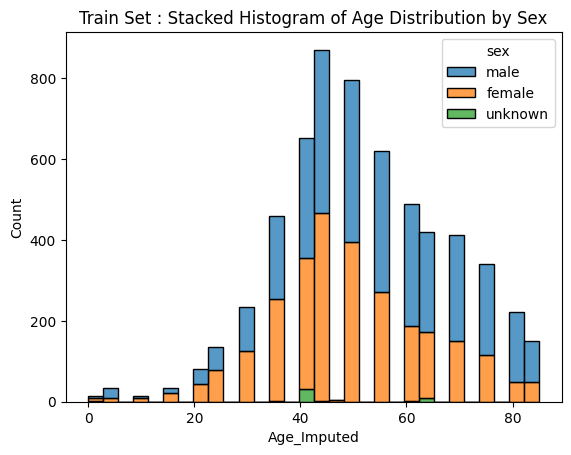

In [36]:
ax = sns.histplot( data=train_df, 
             x='age_imputed', 
             hue='sex', 
             multiple='stack', 
             bins=30 )

ax.set( title='Train Set : Stacked Histogram of Age Distribution by Sex',
       xlabel='Age_Imputed', ylabel='Count' )

[Text(0.5, 1.0, 'Train Set : Stacked Histogram of Age Distribution by dx'),
 Text(0.5, 0, 'Age_Imputed'),
 Text(0, 0.5, 'Count')]

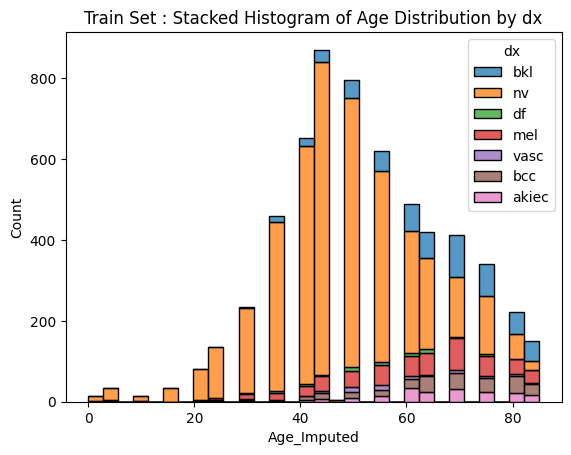

In [37]:
ax = sns.histplot( data=train_df, 
             x='age_imputed', 
             hue='dx', 
             multiple='stack', 
             bins=30 )

ax.set( title='Train Set : Stacked Histogram of Age Distribution by dx',
       xlabel='Age_Imputed', ylabel='Count' )

[Text(0.5, 1.0, 'Test Set : Stacked Histogram of Age Distribution by Sex'),
 Text(0.5, 0, 'Age_Imputed'),
 Text(0, 0.5, 'Count')]

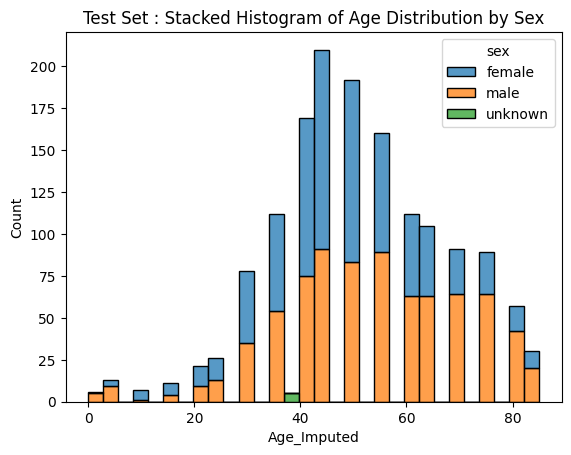

In [38]:
ax = sns.histplot( data=val_df, 
             x='age_imputed', 
             hue='sex', 
             multiple='stack', 
             bins=30 )

ax.set( title='Test Set : Stacked Histogram of Age Distribution by Sex',
       xlabel='Age_Imputed', ylabel='Count' )

[Text(0.5, 1.0, 'Test Set : Stacked Histogram of Age Distribution by dx'),
 Text(0.5, 0, 'Age_Imputed'),
 Text(0, 0.5, 'Count')]

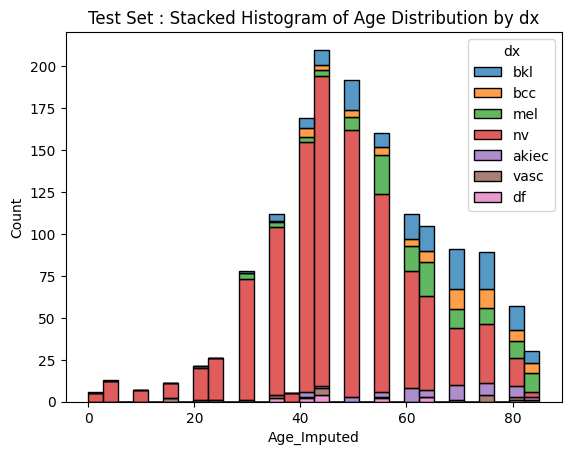

In [39]:
ax = sns.histplot( data=val_df, 
             x='age_imputed', 
             hue='dx', 
             multiple='stack', 
             bins=30 )

ax.set( title='Test Set : Stacked Histogram of Age Distribution by dx',
       xlabel='Age_Imputed', ylabel='Count' )

## **Step 5: Exploratory Data Analysis**

<Axes: title={'center': 'Count of Each Skin Cell Type'}, xlabel='Skin Cell Type', ylabel='Count'>

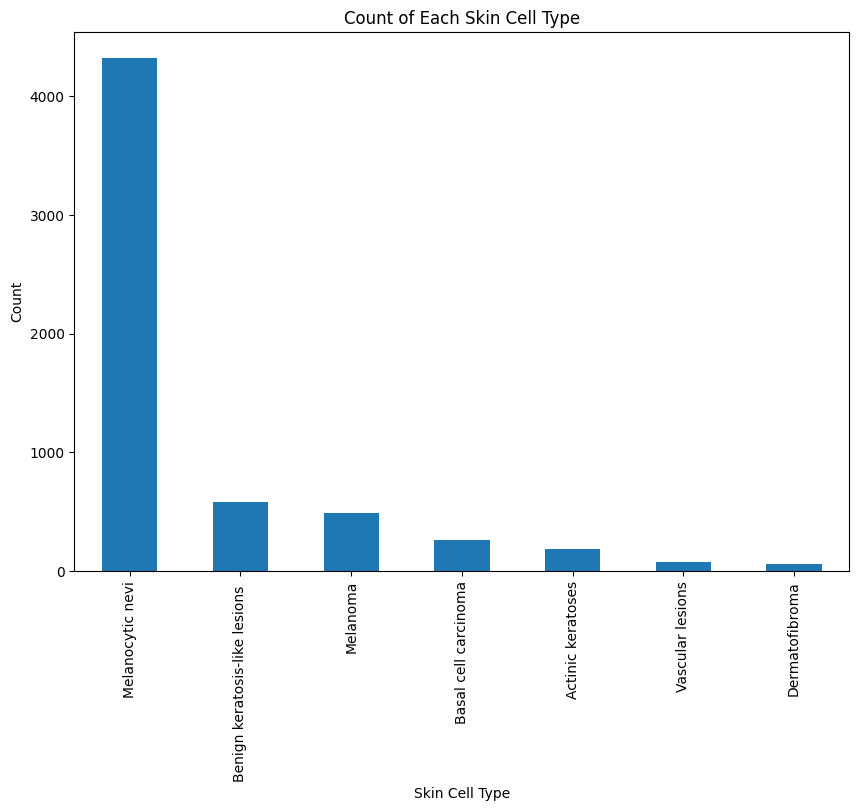

In [44]:
fig, ax1 = plt.subplots( 1, 1, figsize=( 10, 7 ) )
train_df[ 'cell_type' ].value_counts().plot( kind='bar', ax=ax1, title='Count of Each Skin Cell Type', 
                                                  xlabel='Skin Cell Type', ylabel='Count' )

<Axes: xlabel='dx_type'>

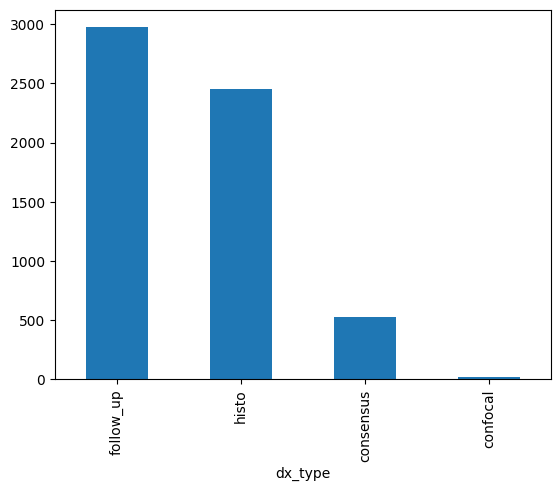

In [45]:
train_df[ 'dx_type' ].value_counts().plot( kind='bar' )

<Axes: xlabel='localization'>

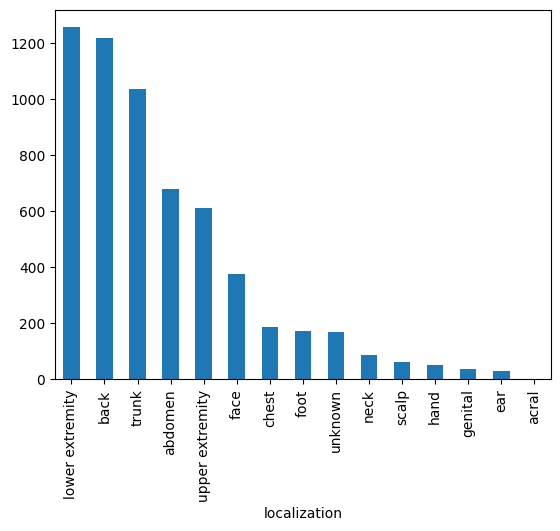

In [46]:
train_df[ 'localization' ].value_counts().plot( kind='bar' )

In [ ]:
train_df[ 'age_imputed' ].hist( bins=40 )

In [ ]:
sns.boxplot( x='age_imputed', y='cell_type', data=train_df )

In [ ]:
fig, ax1 = plt.subplots( 1, 1, figsize=( 10, 7 ) )
val_df[ 'cell_type' ].value_counts().plot( kind='bar', ax=ax1, title='Count of Each Skin Cell Type', 
                                                  xlabel='Skin Cell Type', ylabel='Count' )

In [ ]:
val_df[ 'dx_type' ].value_counts().plot( kind='bar' )

In [ ]:
val_df[ 'localization' ].value_counts().plot( kind='bar' )

In [ ]:
val_df[ 'age_imputed' ].hist( bins=40 )

In [ ]:
sns.boxplot( x='age_imputed', y='cell_type', data=val_df )

## **Step 6: Loading and Resizing of Images**

In [ ]:
train_df[ 'image' ] = train_df[ 'path' ].map(lambda x: np.asarray( Image.open( x ).resize( ( 100, 75 ) ) ) )

In [ ]:
train_df.head()

Show sample of images from each cancer type

In [ ]:
n_samples = 5
fig, axes = plt.subplots( len( skin_lesion_type_dict ), n_samples, figsize = ( 4 * n_samples, 3 * len( skin_lesion_type_dict ) ) )

for n_axes, ( type_name, type_rows ) in zip( axes, train_df.sort_values( [ 'cell_type' ] ).groupby( 'cell_type' ) ):
    n_axes[ 0 ].set_title( f"{ type_name }", fontsize = 16 )
    for ax, ( _, row ) in zip( n_axes, type_rows.sample( n_samples, random_state = 42 ).iterrows() ):
        ax.imshow( row[ 'image' ] )
        ax.axis( 'off' )

if not os.path.exists( "../reports/figures/" ):
    os.makedirs( "../reports/figures/" )

fig.savefig( "../reports/figures/sample_train_skin_lesion_images.png", bbox_inches = 'tight', dpi = 300 )

In [ ]:
train_df[ 'image' ].map( lambda x: x.shape ).value_counts()

In [ ]:
val_df[ 'image' ] = val_df[ 'path' ].map(lambda x: np.asarray( Image.open( x ).resize( ( 100, 75 ) ) ) )

In [ ]:
val_df.head()

Show sample of images from each cancer type

In [ ]:
n_samples = 5
fig, axes = plt.subplots( len( skin_lesion_type_dict ), n_samples, figsize = ( 4 * n_samples, 3 * len( skin_lesion_type_dict ) ) )

for n_axes, ( type_name, type_rows ) in zip( axes, val_df.sort_values( [ 'cell_type' ] ).groupby( 'cell_type' ) ):
    n_axes[ 0 ].set_title( f"{ type_name }", fontsize = 16 )
    for ax, ( _, row ) in zip( n_axes, type_rows.sample( n_samples, random_state = 42 ).iterrows() ):
        ax.imshow( row[ 'image' ] )
        ax.axis( 'off' )

if not os.path.exists( "../reports/figures/" ):
    os.makedirs( "../reports/figures/" )

fig.savefig( "../reports/figures/sample_test_skin_lesion_images.png", bbox_inches = 'tight', dpi = 300 )

In [ ]:
val_df[ 'image' ].map( lambda x: x.shape ).value_counts()

In [ ]:
train_df.drop( columns=[ 'image' ], inplace=True )
train_df.head()

In [ ]:
val_df.drop( columns=[ 'image' ], inplace=True )
val_df.head()

## **Step 7: Feed into the PyTorch Class**

In [ ]:
class ImageBranch( nn.Module ):
    def __init__( self, pretrained = True ):
        super().__init__()
        
        self.resnet = torchvision.models.resnet18( pretrained = pretrained )
        self.resnet.fc = nn.Identity()
    
    def forward( self, x ):
        return self.resnet( x )

In [ ]:
class TabularBranch( nn.Module ):
    def __init__( self, input_dim, hidden_dim, output_dim ):
        super().__init__()
        
        self.fc1 = nn.Linear( input_dim, hidden_dim )
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear( hidden_dim, output_dim )
    
    def forward( self, x ):
        x = self.fc1( x )
        x = self.relu( x )
        x = self.fc2( x )
        return x

In [ ]:
# class SkinLesionDataset( Dataset ):
#     def __init__( self, csv_file, root_dir, transform=None ):
#         self.transform = transform

#         self.root_dir = root_dir

#         # Setup the DataFrame
#         self.df = pd.read_csv( csv_file )

#         # Add additional columns to the DataFrame
#         ## THIS LINE RELIES ON A VARIABLE DEFINED OUTSIDE THE CLASS
#         self.df[ 'path' ] = self.df[ 'image_id' ].map( imageid_path_dict.get )
#         self.df[ 'cell_type' ] = self.df[ 'dx' ].map( skin_lesion_type_dict.get )
#         self.df[ 'cell_type_idx' ] = self.df[ 'cell_type' ].factorize()[ 0 ]

#         # Splitting the DataFrame into Train and Test Sets
#         # features = self.df.drop( columns=[ 'cell_type_idx' ], axis=1 )
#         # target = self.df[ 'cell_type_idx' ]
#         # train_df, val_df = train_test_split( self.df, test_size=0.2, random_state=42, stratify=self.df[ 'cell_type_idx' ] )

#         # Handling Missing Values with Imputation
#         L1_series = self.df.groupby( [ 'sex', 'dx', 'dx_type' ] )[ 'age' ].mean().transform( lambda x: round( x, 0 ) )
#         L2_series = self.df.groupby( [ 'sex', 'dx' ] )[ 'age' ].mean().transform( lambda x: round( x, 0 ) )
#         L3_series = self.df.groupby( [ 'sex' ] )[ 'age' ].mean().transform( lambda x: round( x, 0 ) )
        

#         while self.df.age.isnull().sum() > 0:
#             self.df[ 'age' ] = self.df.groupby( [ 'sex', 'dx', 'dx_type' ] )[ 'age' ].transform( lambda x: x.fillna( round( x.mean( numeric_only = True ), 0 ) ) )
#             if self.df.age.isnull().sum() > 0:
#                 self.df[ 'age' ] = self.df.groupby( [ 'sex', 'dx' ] )[ 'age' ].transform( lambda x: x.fillna( round( x.mean( numeric_only = True ), 0 ) ) )
#             if self.df.age.isnull().sum() > 0:
#                 self.df[ 'age' ] = self.df[ 'age' ].fillna( round( self.df[ 'age' ].mean( numeric_only = True ), 0 ) )

#     def __getitem__( self, idx ):
#         img_name = self.df.iloc[ idx ][ 'path' ]
#         image = Image.open( img_name ).convert( 'RGB' )
#         label = self.df.iloc[ idx ][ 'cell_type_idx' ]

#         if self.transform:
#             image = self.transform( image )

#         return image, label
    
#     def __len__( self ):
#         return len( self.df )